In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import rasterio
import seaborn as sns


In [94]:
def normalize_s3_image(data):
    
    p1, p99 = np.nanpercentile(data.compressed(), [1, 99])
    data = np.clip(data, p1, p99)
    data = (data - p1) / (p99 - p1)
    return data


RasterioIOError: ./data/20200101_20200301_south/S2B_35MQU_20200217_0_L2A/B02_masked.tif: No such file or directory

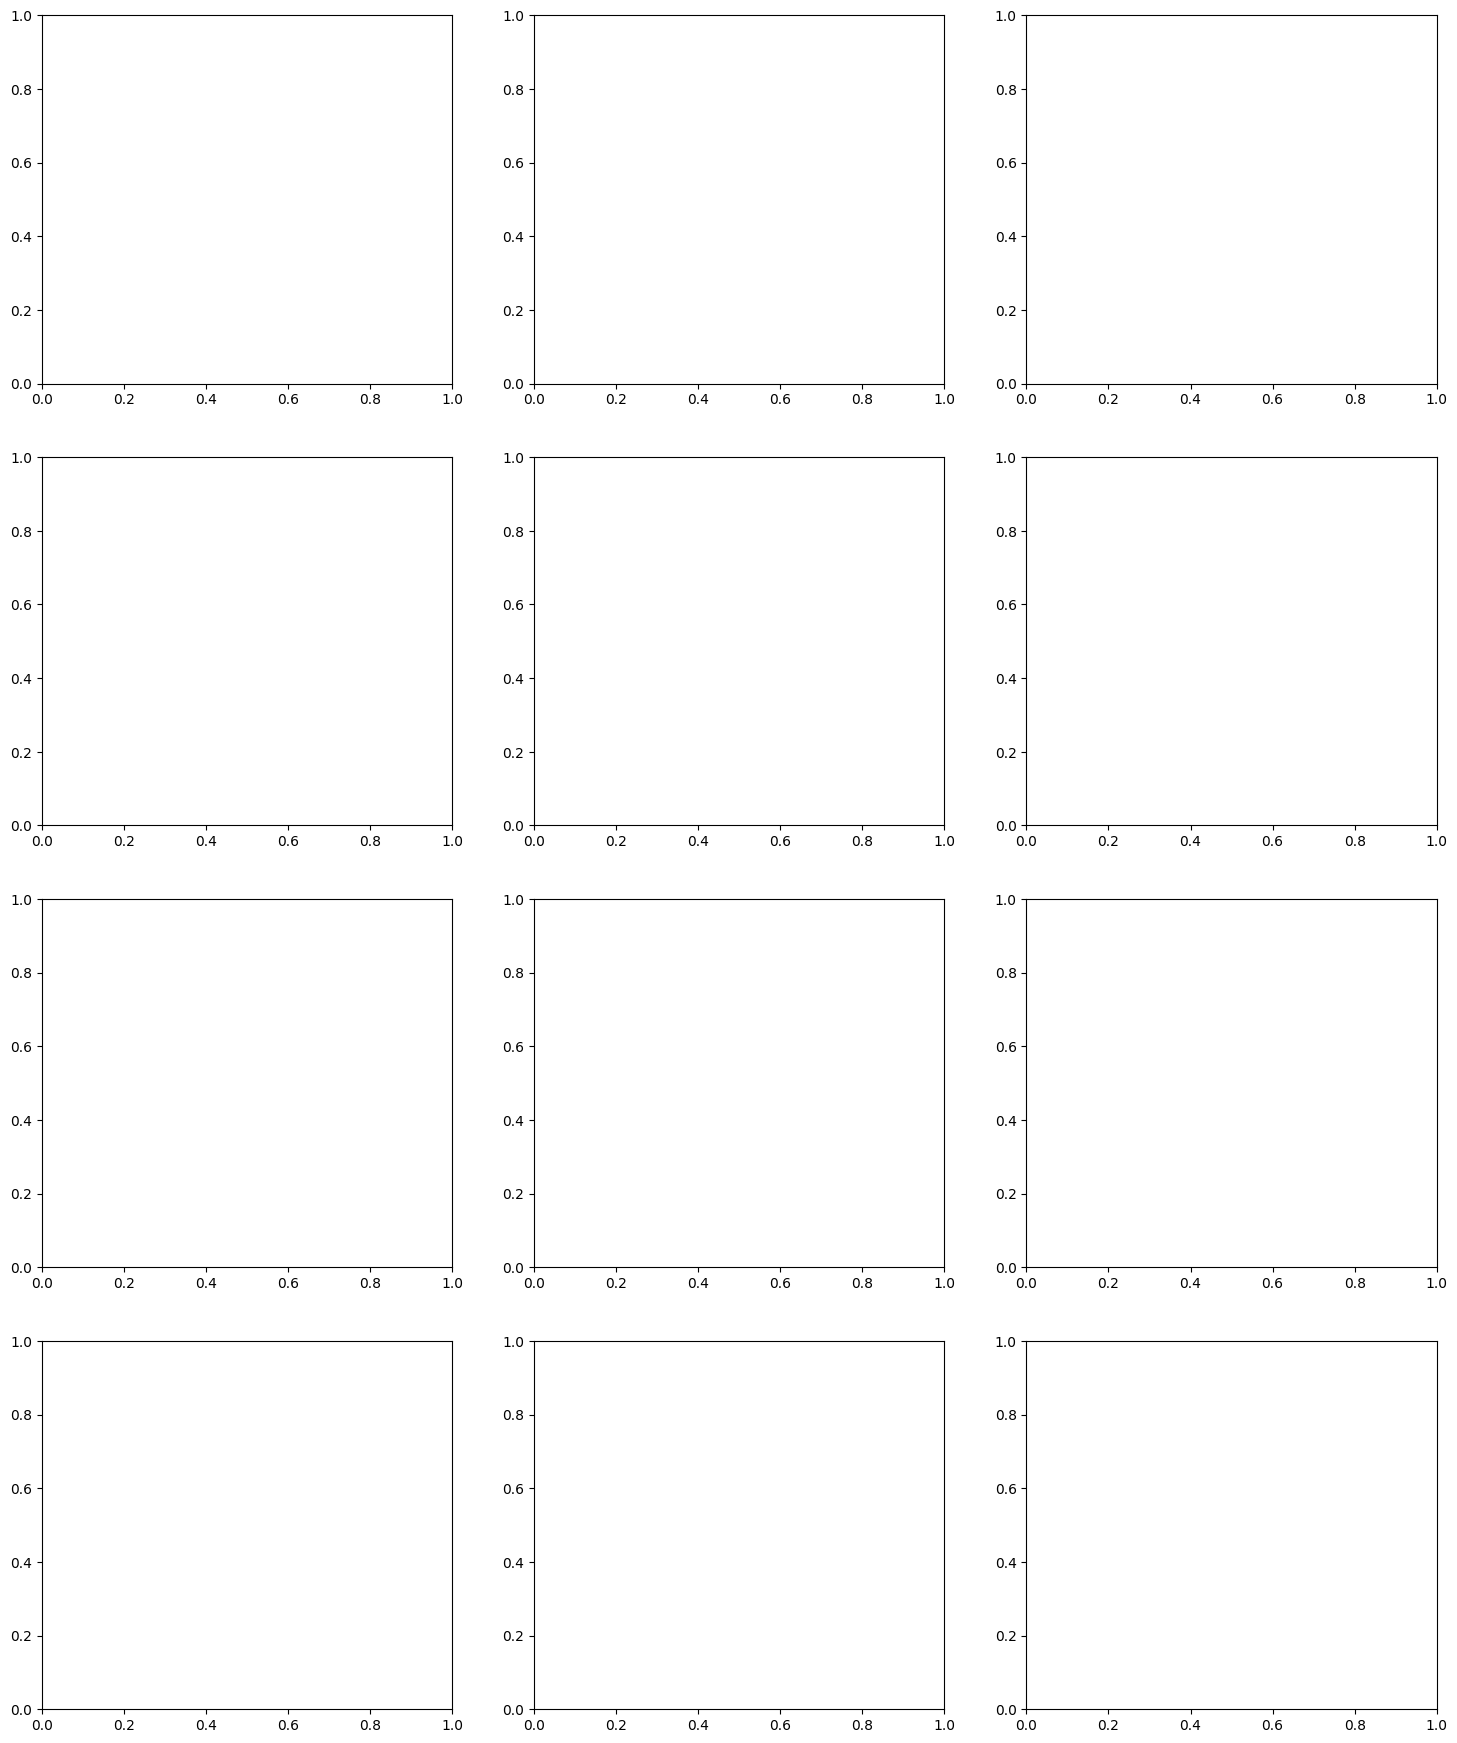

In [2]:

central1 = "./data/20200101_20200301_central/S2A_35MQV_20200123_0_L2A"
central2 = "./data/20200101_20200301_central/S2B_35MQV_20200207_0_L2A"
south1 = "./data/20200101_20200301_south/S2B_35MQU_20200207_0_L2A"
south2 = "./data/20200101_20200301_south/S2B_35MQU_20200217_0_L2A"

scenes = [central1, central2, south1, south2]


bands = ['B02', 'B03', 'B04', 'B08']

fig, rows = plt.subplots(4, 3, figsize=(18, 22))

for i, band in enumerate(bands):
        
    band_path = f'{south2}/{band}_masked.tif'
    with rasterio.open(band_path) as src:
        og_data = src.read(1, masked=True)

    row = rows[i]
    og_hist, og_edges = np.histogram(og_data.compressed(), bins=10)
    og_plot = sns.barplot(x=og_edges[:-1], y=og_hist, ax=row[0])

    og_texts = [t.get_text() for t in og_plot.get_xticklabels()]
    og_ticks = [str(round(float(t))) for t in og_texts]
    og_plot.set_xticklabels(og_ticks)
    row[0].set_title(f'{band} - Original')    
    row[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))

    norm_data = normalize_s3_image(og_data)
    
    norm_hist, norm_edges = np.histogram(norm_data.compressed(), bins=10)
    norm_plot = sns.barplot(x=norm_edges[:-1], y=norm_hist, ax=row[1])
    norm_texts = [t.get_text() for t in norm_plot.get_xticklabels()]
    norm_ticks = [str(round(float(t), 2)) for t in norm_texts]
    norm_plot.set_xticklabels(norm_ticks)
    row[1].set_ylim(row[0].get_ylim())
    row[1].set_title(f'{band} - Normalized')    
    row[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    row[2].imshow(norm_data)
    
plt.show()


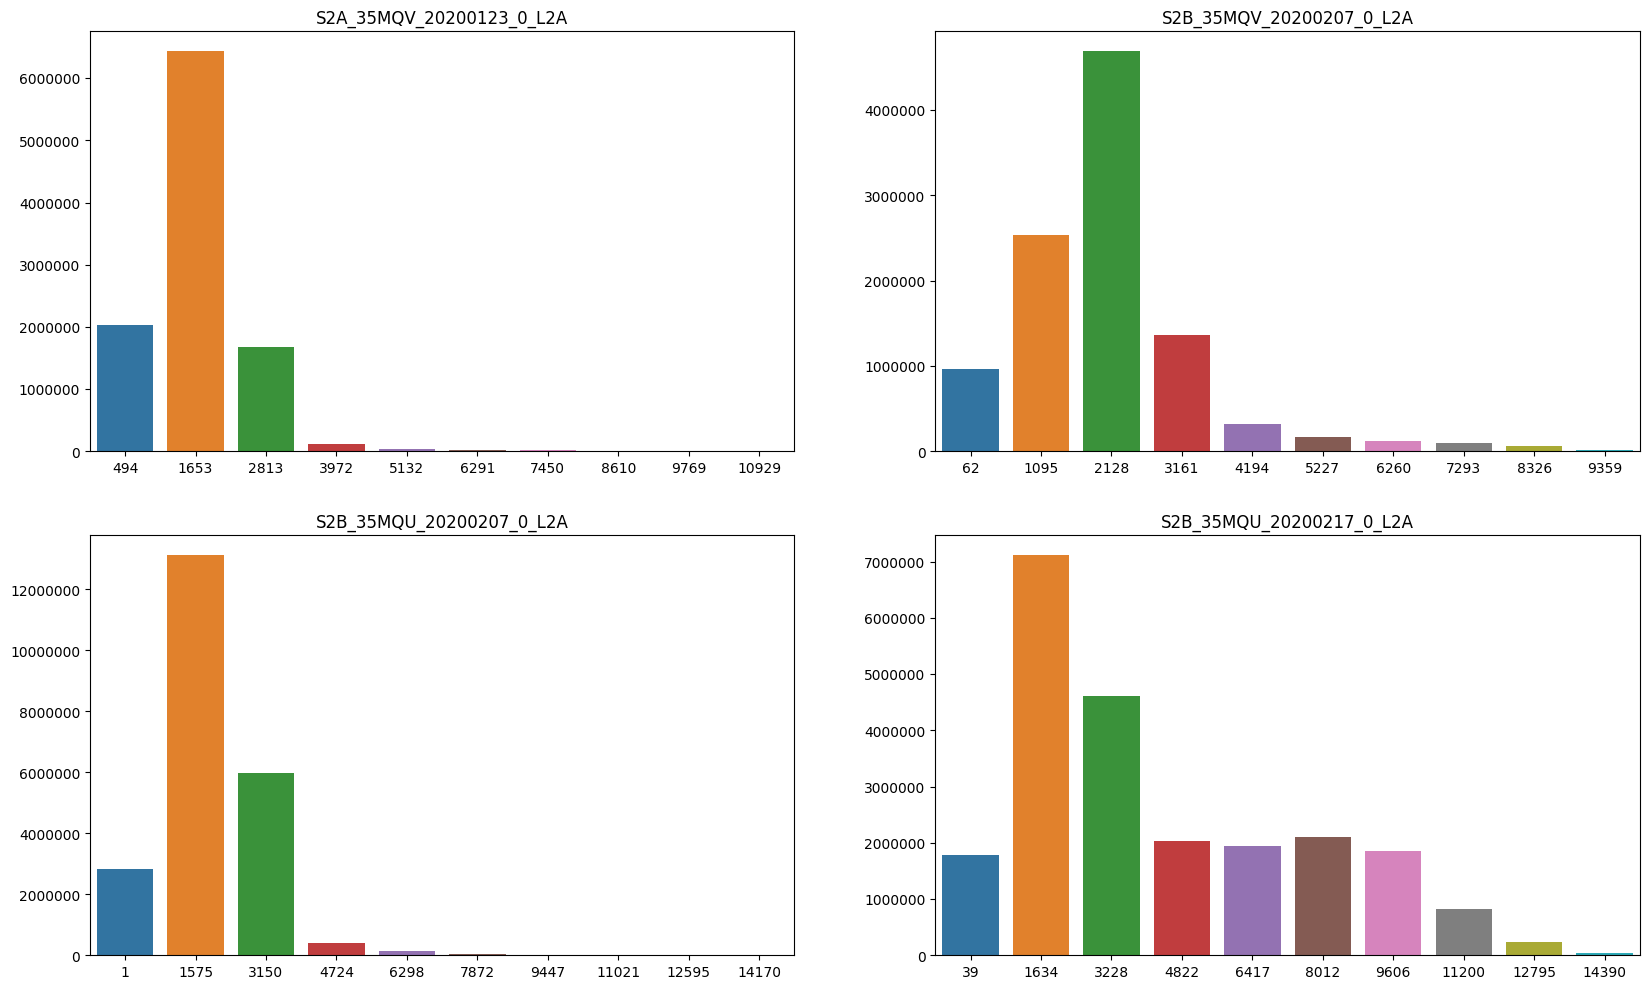

In [57]:
scenes = [central1, central2, south1, south2]

bands = ['B02', 'B03', 'B04', 'B08']

fig, rows = plt.subplots(2, 2, figsize=(20, 12))

for i, scene_path in enumerate(scenes):
    
    scene = scene_path.split('/')[3]
    band_path = f'{scene_path}/B08.tif'
    with rasterio.open(band_path) as src:
        band_data = src.read(1, masked=True)
        hist, edges = np.histogram(band_data, bins=10)
        
    row = i // 2
    col = i % 2
    axis = rows[row][col]
    barplot = sns.barplot(x=edges[:-1], y=hist, ax=axis)
    texts = [t.get_text() for t in barplot.get_xticklabels()]
    ticks = [str(round(float(t))) for t in texts]
    barplot.set_xticklabels(ticks)
    axis.set_title(scene)
    axis.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    

## Testing with stacked image

In [32]:
def normalize_s3_image(data):
    
    data[data.mask] = np.nan   
    norm_data = np.zeros_like(data)
    p1, p99 = np.nanpercentile(data, [1, 99], axis=[1, 2])    
    
    for i in range(p1.shape[0]):
        band_data = np.clip(data[i, :, :], p1[i], p99[i])
        band_data = (band_data - p1[i]) / (p99[i] - p1[i])
        norm_data[i, :, :] = band_data
    
    return norm_data


In [45]:
stack_tif_path = "./data/20200101_20200301_south/S2B_35MQU_20200207_0_L2A/stack_masked.tif"
bands = ['B02', 'B03', 'B04', 'B08', '8A']

with rasterio.open(stack_tif_path) as src:
    num_bands = src.count
    og_data = src.read(masked=True)
    

/var/lang/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


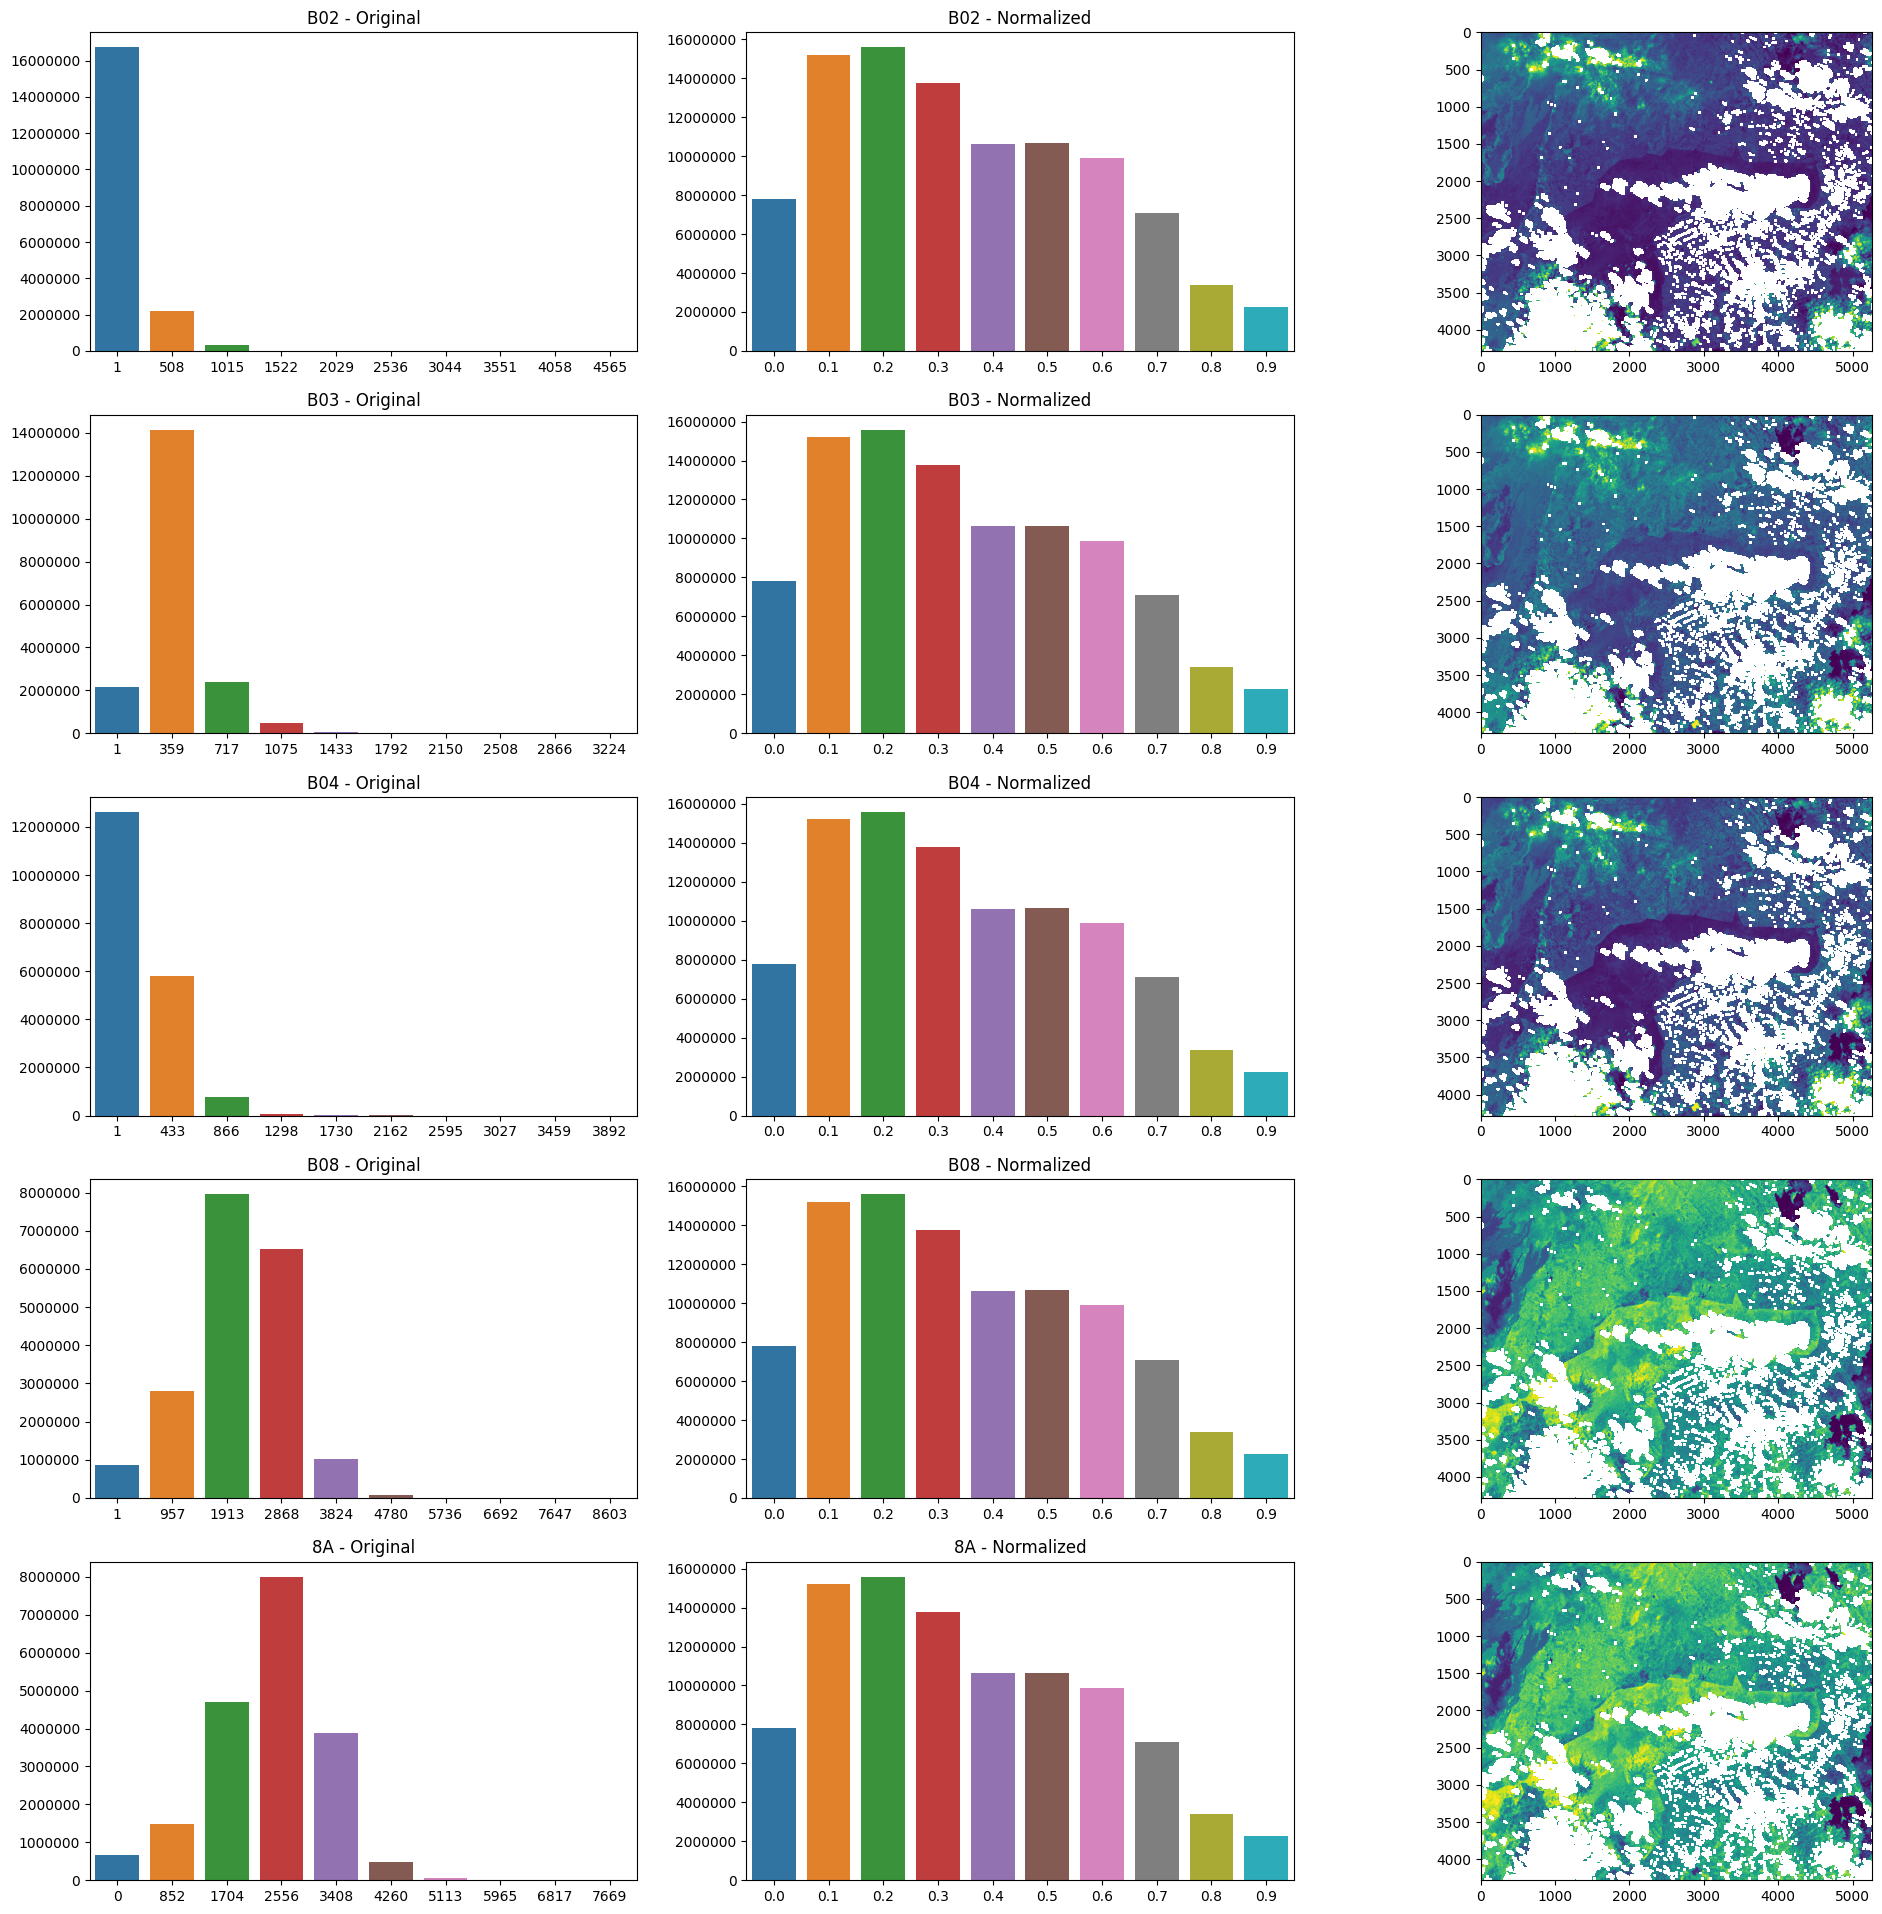

In [46]:

norm_data = normalize_s3_image(og_data.copy())

fig, rows = plt.subplots(num_bands, 3, figsize=(24, 24))

for i in range(num_bands):

    row = rows[i]
    band = bands[i]
    og_band_data = og_data[i, :, :]
    og_hist, og_edges = np.histogram(og_band_data.compressed(), bins=10)
    og_plot = sns.barplot(x=og_edges[:-1], y=og_hist, ax=row[0])
    og_texts = [t.get_text() for t in og_plot.get_xticklabels()]
    og_ticks = [str(round(float(t))) for t in og_texts]
    og_plot.set_xticklabels(og_ticks)
    row[0].set_title(f'{band} - Original')    
    row[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    norm_hist, norm_edges = np.histogram(norm_data.compressed(), bins=10)
    norm_plot = sns.barplot(x=norm_edges[:-1], y=norm_hist, ax=row[1])
    norm_texts = [t.get_text() for t in norm_plot.get_xticklabels()]
    norm_ticks = [str(round(float(t), 2)) for t in norm_texts]
    norm_plot.set_xticklabels(norm_ticks)
    #row[1].set_ylim(row[0].get_ylim())
    row[1].set_title(f'{band} - Normalized')    
    row[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    row[2].imshow(norm_data[i, :, :])
    

### RGB normalization

In [1]:
%reload_ext autoreload
%autoreload 2

from datetime import datetime as dt

dst_dir = "./data/norm"
cloud_mask_model_path = "./best_resnet18_dice_cloud_detection.pth"

bbox_bare = [18.529903, 15.759188, 18.546018, 15.774155]
bbox_forest = [25.005236, -1.722728, 25.025718, -1.704964]
bbox_grass = [29.481436, -0.717711, 29.498882, -0.702594]
bbox_ocean = [72.466336, -7.294868, 72.515565, -7.253983]

start_date = dt(2019, 1, 1)
end_date = dt(2023, 3, 1)


In [98]:
%reload_ext autoreload
%autoreload 2

from common.utilities.download import get_collection, get_processed_composite

#bare_collection_path = f'{dst_dir}/bare/collection.json'
#bare_collection = get_collection(start_date, end_date, bbox_bare, bare_collection_path, max_cloud_cover=10, max_tile_count=2, min_tile_count=1)
#bare_composite_path = get_processed_composite(bare_collection, bbox_bare, f'{dst_dir}/bare', cloud_mask_model_path)
#print(bare_composite_path)

In [110]:
import numpy as np
import rasterio
from skimage import exposure


def norm_rgb(composite_path):
    
    with rasterio.open(composite_path) as src:
        bbox = list(src.bounds)
        rgb_stack = src.read((3, 2, 1), masked=True)
        
    """
    rgb_stack = np.clip(rgb_stack * 254 + 20, 0, 254).astype(np.uint8) # brighten a bit
    return rgb_stack
    """

    gamma = 0.6
    gamma_stack = np.zeros_like(rgb_stack)
    for i in range(3):
        channel = rgb_stack[i, :, :]
        gamma_stack[i, :, :] = exposure.adjust_gamma(channel, gamma)
                
    gamma_stack = np.clip(gamma_stack * 254, 0, 254).astype(np.uint8)
    
    print(type(gamma_stack))
    
    return gamma_stack



In [5]:
from common.utilities.download import get_collection, get_processed_composite

forest_collection_path = f'{dst_dir}/forest/collection.json'
forest_collection = get_collection(start_date, end_date, bbox_forest, forest_collection_path, max_cloud_cover=10, max_tile_count=2, min_tile_count=1)
forest_composite_path = get_processed_composite(forest_collection, bbox_forest, f'{dst_dir}/forest', cloud_mask_model_path)
print(forest_composite_path)

./data/norm/forest/collection.json: {'KU': 2}
./data/norm/forest/composite.tif


<class 'numpy.ma.core.MaskedArray'>


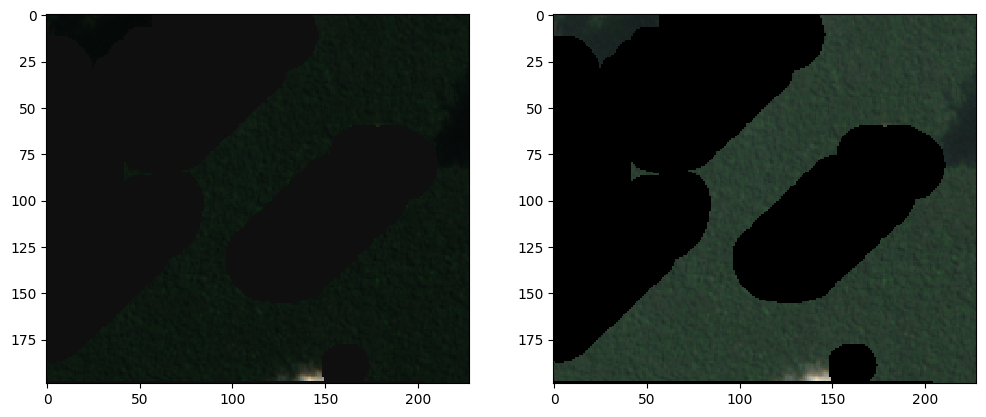

In [111]:
import matplotlib.pyplot as plt
import rasterio
from common.utilities.visualization import plot_bands

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

with rasterio.open(forest_composite_path) as src:
    og_data = src.read(masked=True)
    
plot_bands(og_data, ax=ax1, bands=[2, 1, 0], transpose=True)
    
rgb_data = norm_rgb(forest_composite_path)
plot_bands(rgb_data, ax=ax2, bands=[0, 1, 2], transpose=True)


In [9]:
from common.utilities.download import get_collection

ocean_collection_path = f'{dst_dir}/ocean/collection.json'
ocean_collection = get_collection(start_date, end_date, bbox_ocean, ocean_collection_path, max_cloud_cover=10, max_tile_count=2, min_tile_count=1)
ocean_composite_path = get_processed_composite(ocean_collection, bbox_ocean, f'{dst_dir}/ocean', cloud_mask_model_path)
print(ocean_composite_path)

./data/norm/ocean/collection.json: {'ZS': 2, 'BM': 2, 'BN': 2, 'ZT': 2}
./data/norm/ocean/composite.tif


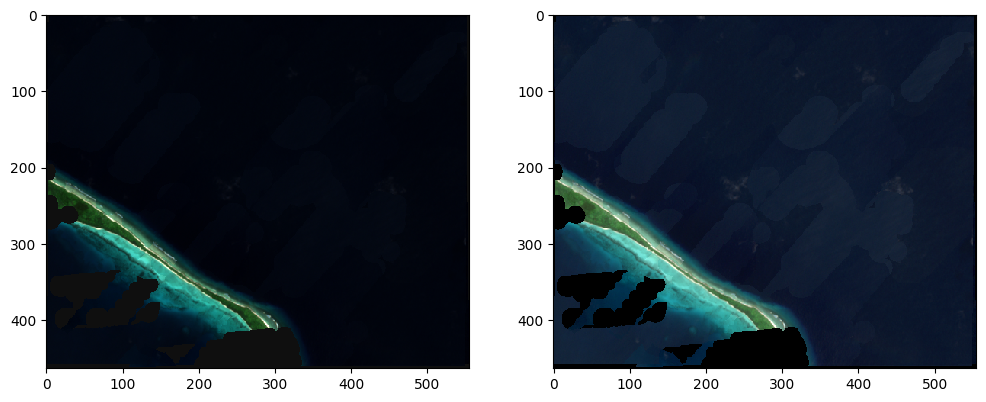

In [107]:
import matplotlib.pyplot as plt
import rasterio
from common.utilities.visualization import plot_bands

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

with rasterio.open(ocean_composite_path) as src:
    og_data = src.read(masked=True)
    
plot_bands(og_data, ax=ax1, bands=[2, 1, 0], transpose=True)
    
rgb_data = norm_rgb(ocean_composite_path)
plot_bands(rgb_data, ax=ax2, bands=[0, 1, 2], transpose=True)


In [109]:
from common.utilities.download import get_collection

grass_collection_path = f'{dst_dir}/grass/collection.json'
grass_collection = get_collection(start_date, end_date, bbox_grass, grass_collection_path, max_cloud_cover=10, max_tile_count=4, min_tile_count=1)
grass_composite_path = get_processed_composite(grass_collection, bbox_grass, f'{dst_dir}/grass', cloud_mask_model_path)
print(grass_composite_path)

./data/norm/grass/collection.json: {'QV': 4}
	downloading... S2A_35MQV_20190508_1_L2A
	downloading... S2B_35MQV_20200904_0_L2A
	downloading... S2A_35MQV_20200820_0_L2A
	downloading... S2A_35MQV_20201118_0_L2A
	masking... S2A_35MQV_20190508_1_L2A
		skipping S2A_35MQV_20190508_1_L2A, too many clouds
	masking... S2B_35MQV_20200904_0_L2A
		skipping S2B_35MQV_20200904_0_L2A, too many clouds
	masking... S2A_35MQV_20200820_0_L2A
		skipping S2A_35MQV_20200820_0_L2A, too many clouds
	masking... S2A_35MQV_20201118_0_L2A
		skipping S2A_35MQV_20201118_0_L2A, too many clouds


IndexError: list index out of range